# 创建cerebro的实例并导入数据

In [5]:
import pandas as pd
import backtrader as bt 
import matplotlib.pyplot as plt

# 定义下载的文件
data_file = "GC=F_historical_data.csv"
column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# 使用 pandas 读取 CSV 文件，跳过前三行 (header=3)，并且手动指定列名
df = pd.read_csv(
    data_file,
    header=None,
    skiprows=3,
    names=column_names, # 手动指定列名
    index_col=0,   # 将第一列（日期）设置为索引
    parse_dates=True # 将索引列解析为日期时间对象
)

if 'Adj Close' not in df.columns:
    df['Adj Close'] = df['Close']

# 我们需要重新排列一下 df 的列
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
# 打印数据的前几行和列信息，方便调试
print("Pandas DataFrame 前几行：")
print(df.head())
print("\nPandas DataFrame 列信息：")
print(df.info())

Pandas DataFrame 前几行：
                  Open        High         Low       Close  Volume   Adj Close
Date                                                                          
2000-08-30  273.899994  273.899994  273.899994  273.899994       0  273.899994
2000-08-31  274.799988  278.299988  274.799988  278.299988       0  278.299988
2000-09-01  277.000000  277.000000  277.000000  277.000000       0  277.000000
2000-09-05  275.799988  275.799988  275.799988  275.799988       2  275.799988
2000-09-06  274.200012  274.200012  274.200012  274.200012       0  274.200012

Pandas DataFrame 列信息：
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6106 entries, 2000-08-30 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6106 non-null   float64
 1   High       6106 non-null   float64
 2   Low        6106 non-null   float64
 3   Close      6106 non-null   float64
 4   Volume     6106 non-null   int64 

# 定义双均线策略

In [6]:
class DualMovingAverage(bt.Strategy):
    # 定义策略的参数
    params = (('fast_length', 25), # 快速移动平均线周期
              ('slow_length', 200), # 慢速移动平均线周期
             )
    
    def __init__(self):
        # 记录收盘价，方便后续使用
        self.dataclose = self.datas[0].close
        # 用来跟踪未完成的订单
        self.order = None
        self.buyprice = None # 记录买入价格
        self.comm = None     # 记录佣金
        # 创建两条移动平均线指标
        self.fast_ma = bt.indicators.SMA(self.dataclose, period=self.p.fast_length)
        self.slow_ma = bt.indicators.SMA(self.dataclose, period=self.p.slow_length)
        # 我们将不再使用 bt.indicators.CrossOver 指标，直接在 next 方法中判断交叉
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单已提交/接受，等待执行
            return
        # 如果订单是完成状态 (买入/卖出)
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.comm = order.executed.comm
                print(f"买入执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            elif order.issell():
                print(f"卖出执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            self.bar_executed = len(self) # 记录订单执行时的 bar 数量
        # 如果订单是取消、保证金不足、拒绝等状态
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"订单状态: {order.Status[order.status]} - 日期: {self.data.datetime.date()}")
        # 重置订单跟踪，表示没有未完成的订单了
        self.order = None

    def notify_trade(self, trade):
        # 交易完成（平仓）时调用
        if not trade.isclosed:
            return
        print(f"交易完成 - 毛利润: {trade.pnl:.2f}, 净利润: {trade.pnlcomm:.2f}")
        
    def next(self):
        # 确保两条均线都有足够的数据点来计算
        # SMA 需要至少 period 数量的数据点才能计算出第一个值
        if len(self) < max(self.p.fast_length, self.p.slow_length):
            return # 数据不足，跳过
        # 如果有未完成的订单，则不进行新的操作
        if self.order:
            return
        # 检查是否持有仓位 (即当前是否持有股票/期货)
        if not self.position: # 没有持仓
            # 判断金叉信号：快速均线向上穿过慢速均线
            # 当前快速均线 > 当前慢速均线 AND 上一周期快速均线 < 上一周期慢速均线
            if self.fast_ma[0] > self.slow_ma[0] and self.fast_ma[-1] < self.slow_ma[-1]:
                # 买入
                self.order = self.buy(size=10) # 假设买入10个单位
                print(f"发出买入信号 - 日期: {self.data.datetime.date()}, 快速均线: {self.fast_ma[0]:.2f}, 慢速均线: {self.slow_ma[0]:.2f}")
        else: # 持有仓位 (做多)
            # 判断死叉信号：快速均线向下穿过慢速均线
            # 当前快速均线 < 当前慢速均线 AND 上一周期快速均线 > 上一周期慢速均线
            if self.fast_ma[0] < self.slow_ma[0] and self.fast_ma[-1] > self.slow_ma[-1]:
                # 卖出（平仓）
                self.order = self.close() # 平仓所有持仓
                print(f"发出卖出信号 - 日期: {self.data.datetime.date()}, 快速均线: {self.fast_ma[0]:.2f}, 慢速均线: {self.slow_ma[0]:.2f}")

# 将策略添加到 Cerebro 引擎并运行回测

In [7]:
# 创建一个 Cerebro 引擎（回测的大脑）
cerebro = bt.Cerebro()

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns_analyzer", timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio", timeframe=bt.TimeFrame.Years) # 添加夏普比率
# 创建数据 Feed
data = bt.feeds.PandasData(
    dataname=df,
    # fromdate=datetime.datetime(2020, 1, 2), # 使用 datetime 模块指定日期
    # todate=datetime.datetime(2025, 12, 31),
    timeframe=bt.TimeFrame.Days # 明确指定数据的时间框架是日线
)

# 将数据 Feed 添加到 Cerebro 引擎
cerebro.adddata(data)
# 添加策略到 Cerebro 引擎
cerebro.addstrategy(DualMovingAverage)
# 设置初始资金
cerebro.broker.setcash(100000.0) # 初始资金 100,000
# 设置佣金 (这里设置为万分之一，可以根据实际情况调整)
cerebro.broker.setcommission(commission=0.0001)
# 打印初始资金
print(f"初始资金: {cerebro.broker.getvalue():.2f}")
# 运行回测
results = cerebro.run()  # 建议将变量名改为复数形式，以提醒自己它是一个列表
thestrat = results[0]    # 获取列表中的第一个策略实例

# 打印最终资金
print(f"最终资金: {cerebro.broker.getvalue():.2f}")

# 通过策略实例访问分析器
trade_analyzer = thestrat.analyzers.trade_analyzer.get_analysis()
returns_analyzer = thestrat.analyzers.returns_analyzer.get_analysis()
sharpe_ratio = thestrat.analyzers.sharpe_ratio.get_analysis()

# 打印分析结果
if trade_analyzer.total.closed > 0:
    print(f"总收益率: {returns_analyzer.get('rtot', 0) * 100:.2f}%")
    print(f"总交易次数: {trade_analyzer.total.closed}")
else:
    print("没有发生任何交易。")

# 夏普比率可能为 None，需要检查
sharpe_ratio_value = sharpe_ratio.get('sharperatio')
if sharpe_ratio_value is not None:
    print(f"夏普比率: {sharpe_ratio_value:.4f}")
else:
    print("夏普比率: N/A")

# 绘制图表
cerebro.plot()

初始资金: 100000.00
发出买入信号 - 日期: 2003-05-02, 快速均线: 330.51, 慢速均线: 330.43
买入执行 - 日期: 2003-05-05, 价格: 342.30, 成本: 3423.00, 佣金: 0.34
发出卖出信号 - 日期: 2004-05-14, 快速均线: 391.18, 慢速均线: 392.63
卖出执行 - 日期: 2004-05-17, 价格: 379.50, 成本: 3423.00, 佣金: 0.38
交易完成 - 毛利润: 372.00, 净利润: 371.28
发出买入信号 - 日期: 2004-07-20, 快速均线: 398.84, 慢速均线: 398.23
买入执行 - 日期: 2004-07-21, 价格: 401.80, 成本: 4018.00, 佣金: 0.40
发出卖出信号 - 日期: 2004-07-30, 快速均线: 398.18, 慢速均线: 398.71
卖出执行 - 日期: 2004-08-02, 价格: 394.00, 成本: 4018.00, 佣金: 0.39
交易完成 - 毛利润: -78.00, 净利润: -78.80
发出买入信号 - 日期: 2004-09-02, 快速均线: 401.90, 慢速均线: 401.34
买入执行 - 日期: 2004-09-03, 价格: 400.50, 成本: 4005.00, 佣金: 0.40
发出卖出信号 - 日期: 2005-05-27, 快速均线: 425.07, 慢速均线: 425.15
卖出执行 - 日期: 2005-05-31, 价格: 418.00, 成本: 4005.00, 佣金: 0.42
交易完成 - 毛利润: 175.00, 净利润: 174.18
发出买入信号 - 日期: 2005-06-27, 快速均线: 427.78, 慢速均线: 427.74
买入执行 - 日期: 2005-06-28, 价格: 436.00, 成本: 4360.00, 佣金: 0.44
发出卖出信号 - 日期: 2005-07-22, 快速均线: 429.32, 慢速均线: 429.36
卖出执行 - 日期: 2005-07-25, 价格: 425.70, 成本: 4360.00, 佣金: 0.43
交易完成 - 毛利润: -103

<IPython.core.display.Javascript object>

[[<Figure size 3600x1800 with 4 Axes>]]

# 可视化回测结果

<IPython.core.display.Javascript object>

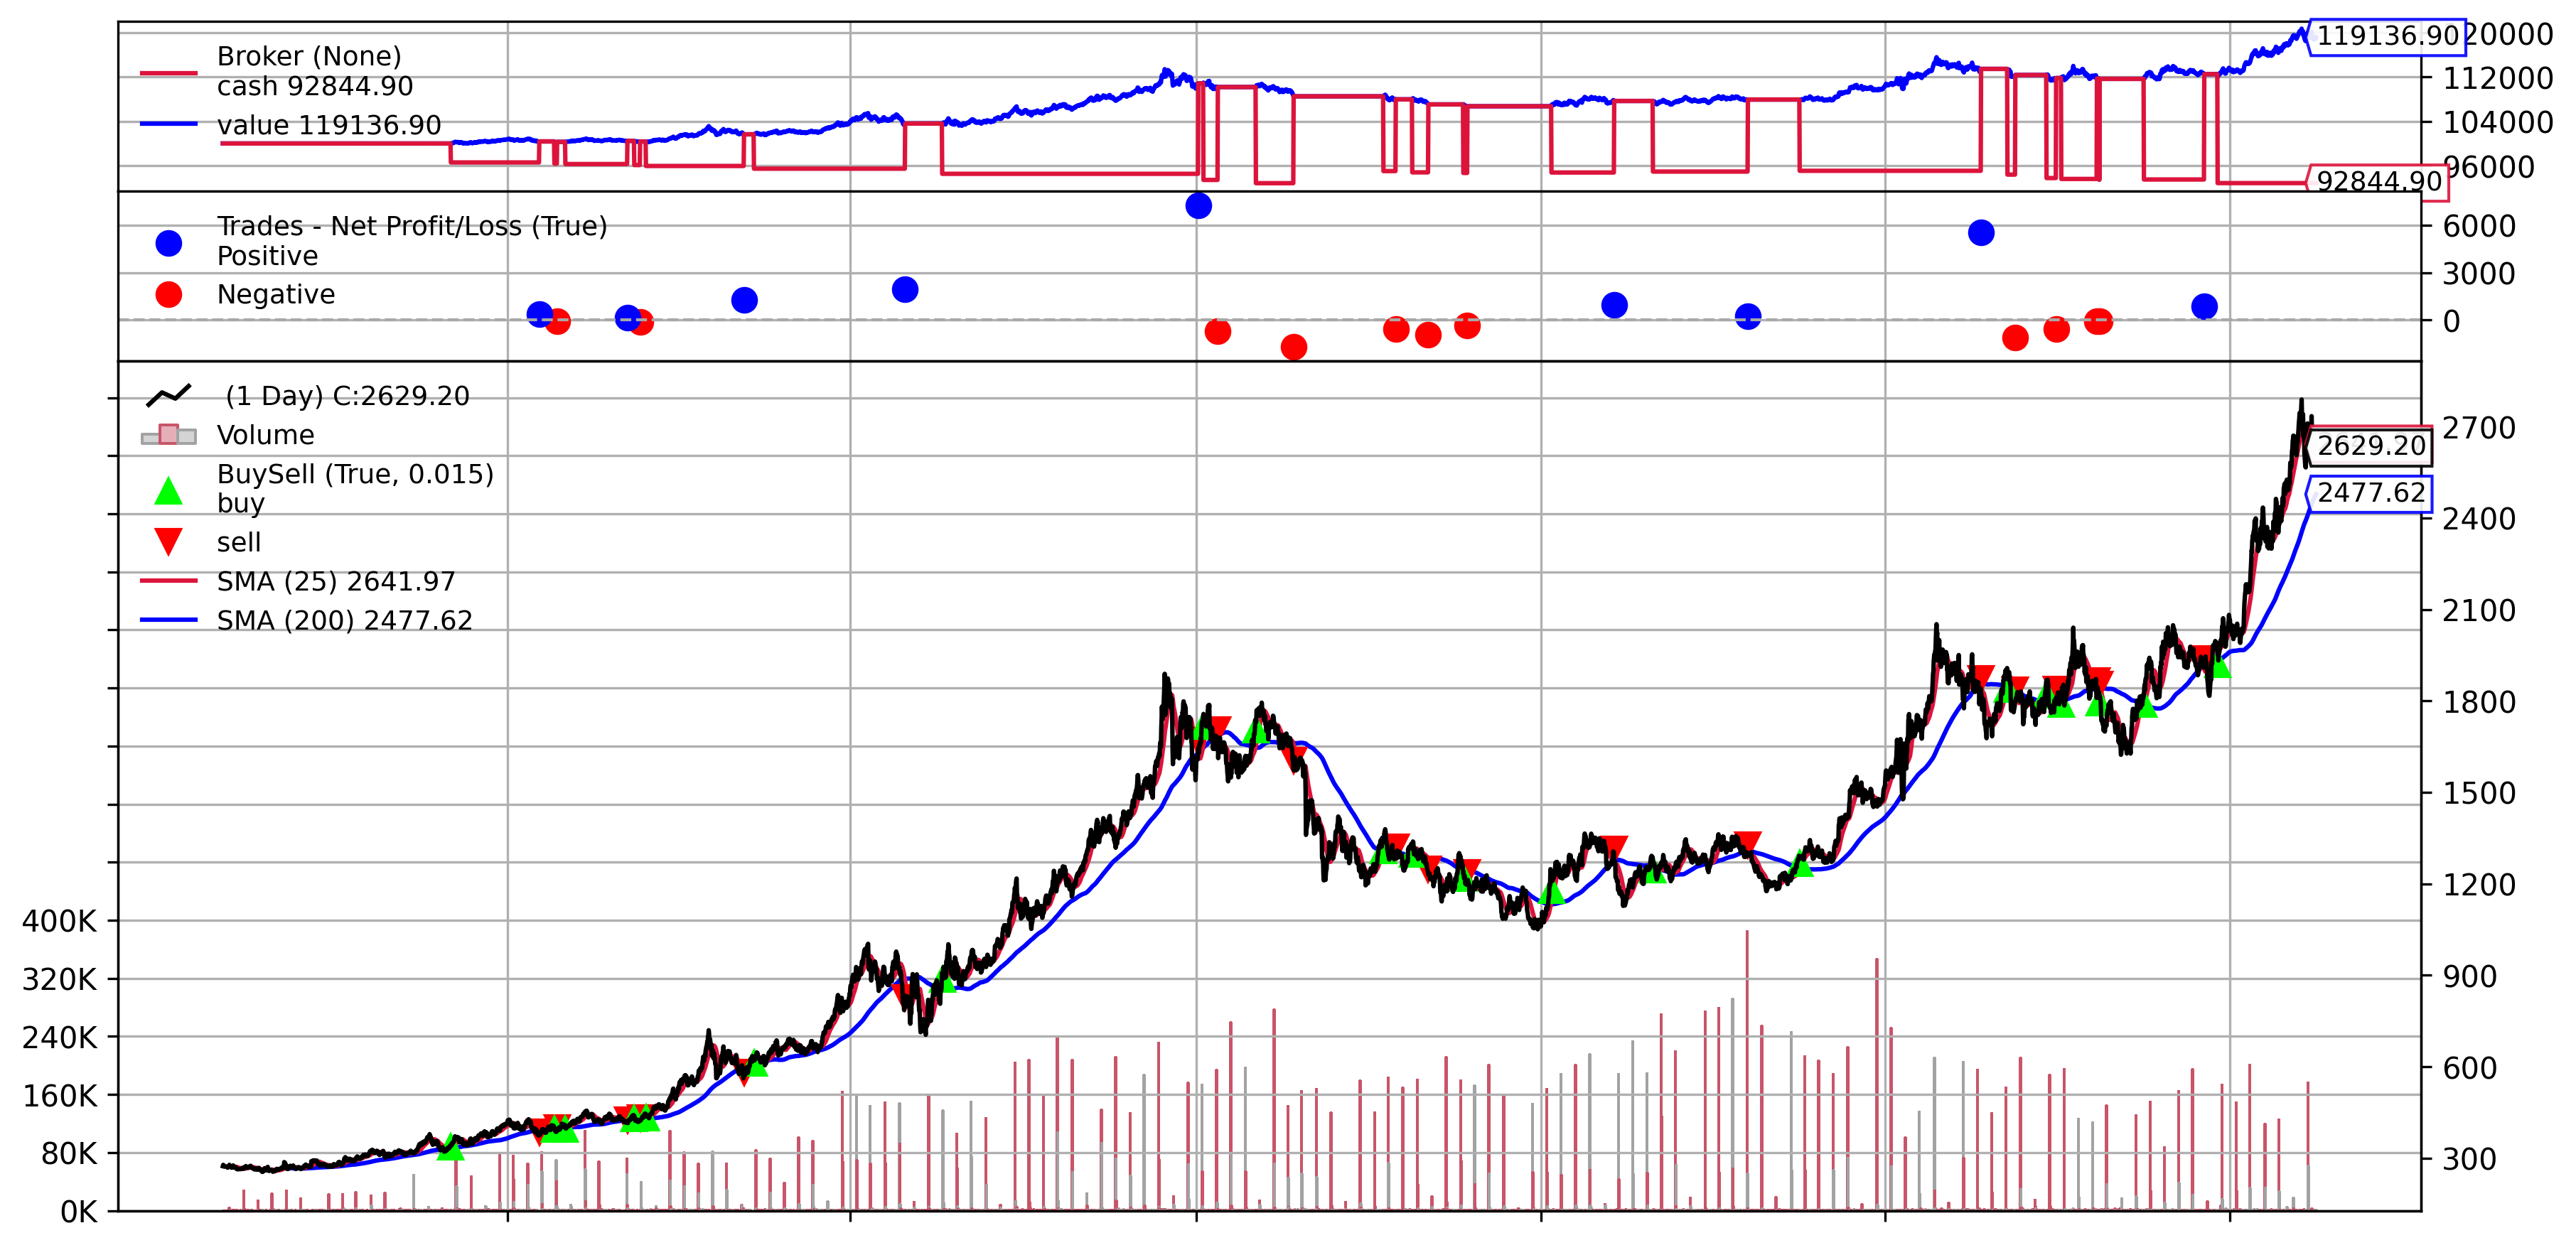

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 300
cerebro.plot()[0][0]